**The problem statement**

Your task is to make:

- daily MRR (Monthly Recurring Revenue) forecasts for 30 days ahead,
- monthly MRR forecasts for 3 months ahead.

We expect to see 20% increase (linear growth) of ARPU (Average Revenue Per User) within 3 months
(from January to March) - please include that assumption in your forecasts.

The forecasts.xlsx file contains daily information about ARPU, MRR, new projects and customers.
- Segment X MRR –> monthly recurring revenue on a given date
- Project created –> number of new projects created that day
- Customers added –> number of new paid customers on a given date
- Purchase conversion rate –> Customers added / project created
- Customers churned -> paid customers that stopped paying for our service
- New net paid customers – difference between customers added and customers churned
- Total paid customers – how many paying customers we have on a given day
- ARPU – average revenue per user

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from loess.loess_1d import loess_1d

In [2]:
seg = pd.read_csv('segment-1.csv')

In [3]:
seg['month'] = seg['Date'].apply(lambda x: x[0:2])

In [34]:
seg.dtypes

Date                         object
Segment 1 MRR               float64
Project created               int64
Purchase conversion rate    float64
Customers added               int64
Customers churned             int64
New Net Paid Customers        int64
Total paid customers          int64
ARPU                        float64
month                        object
dtype: object

# Check if LOESS gives acceptable results

## Predict daily MRR

In [16]:
from sklearn.neighbors import RadiusNeighborsRegressor

In [ ]:
X = seg['ARPU'].iloc[0:200]
y = seg['Segment 1 MRR'].iloc[0:200]

In [17]:
rnr = RadiusNeighborsRegressor(radius = 1.0)

In [19]:
rnr.fit(X.to_numpy().reshape(-1, 1), y)

RadiusNeighborsRegressor()

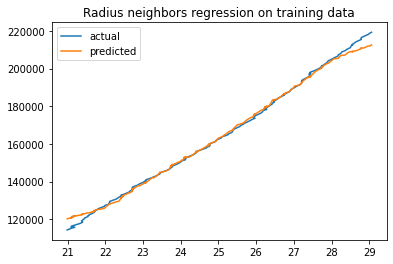

In [22]:
plt.plot(X.to_numpy(), y.to_numpy(), label = 'actual')
plt.plot(X.to_numpy(), rnr.predict(X.to_numpy().reshape(-1, 1)), label = 'predicted')
plt.title('Radius neighbors regression on training data')
ignore = plt.legend()

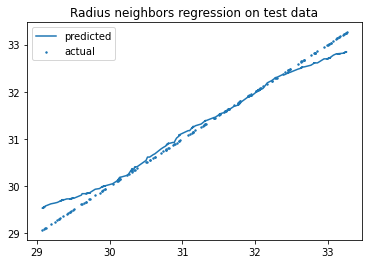

In [32]:
X_new = seg['ARPU'].iloc[200:365]
y_actual = seg['ARPU'].iloc[200:365]
y_predicted = rnr.predict(X_new.to_numpy().reshape(-1, 1))

plt.scatter(X_new.to_numpy(), y_actual.to_numpy(), label = 'actual', s = 2)
plt.plot(X_new.to_numpy(), y_predicted, label = 'predicted')
plt.title('Radius neighbors regression on test data')
igoore = plt.legend()

In [30]:
from sklearn.metrics import mean_squared_error, r2_score

print(f'MSE = {mean_squared_error(y_actual, y_predicted)}.')
print(f'R2 = {r2_score(y_actual, y_predicted)}')

MSE = 0.036225301027778836.
R2 = 0.9762128164046693


## Predict monthly MRR

In [53]:
seg_agg = seg[['month', 'ARPU', 'Segment 1 MRR']].groupby('month').sum()

In [81]:
seg_agg['cosine'] = np.cos(seg_agg['ARPU'])

In [83]:
X = seg_agg[['ARPU', 'cosine']].iloc[0:9].to_numpy()
y = seg_agg['Segment 1 MRR'].iloc[0:9].to_numpy()
X_new = seg_agg[['ARPU', 'cosine']].iloc[9:12].to_numpy()
y_actual = seg_agg['Segment 1 MRR'].iloc[9:12].to_numpy()

In [84]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

In [85]:
lr.fit(X, y)

LinearRegression()

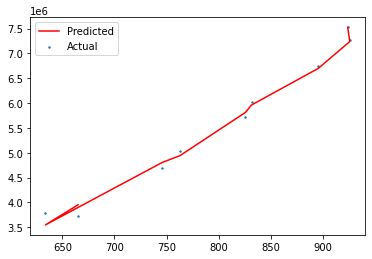

In [91]:
y_pred = lr.predict(X)
plt.scatter(X[0:9, 0], y, s = 2, label = 'Actual')
plt.plot(X[0:9, 0], y_pred, label = 'Predicted', color = 'red')
plt.legend()
ignore = plt.title('Training data performance')

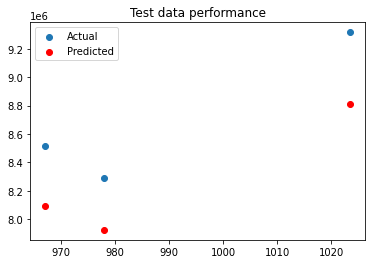

In [97]:
y_pred = lr.predict(X_new)
plt.scatter(X_new[0:3, 0], y_actual, label = 'Actual')
plt.scatter(X_new[0:3, 0], y_pred, label = 'Predicted', color = 'red')
plt.legend()
ignore = plt.title('Test data performance')

In [98]:
comparison = pd.DataFrame({'ARPU': X_new[0:3, 0], \
                           'Actual-MRR': y_actual, \
                           'Predicted-MRR': y_pred})

In [100]:
comparison['pct-error'] = (comparison['Predicted-MRR'] - comparison['Actual-MRR'])/comparison['Actual-MRR']

In [101]:
comparison

,ARPU,Actual-MRR,Predicted-MRR,pct-error
0,978.09,8288816.27,7.925096e+06,-0.043881
1,967.18,8518945.25,8.093928e+06,-0.049891
2,1023.41,9315712.71,8.812063e+06,-0.054065


# Build models using the entire data